# Sentinel-1 SLC preprocessing + OpenEO custom processes

In [1]:
import openeo

import rasterio
from rasterio.plot import show

import matplotlib.pyplot as plt

In [2]:
url = "https://openeo.dataspace.copernicus.eu"
connection = openeo.connect(url).authenticate_oidc()

Authenticated using refresh token.


## 1) Create a datacube with coregistered Sentinel-1 SLC

In [3]:
slc_datacube = openeo.rest.datacube.DataCube(
    openeo.rest.datacube.PGNode(
        "insar_preprocessing_v02",
        arguments={
            "burst_id": 249435,
            "sub_swath": "IW2",
            "temporal_extent": [
                "2024-08-01",
                "2024-09-02"
            ],
            "master_date": "2024-08-09",
            "polarization": "vh"
        },
    ),
    connection=connection,
)

slc_datacube = slc_datacube.save_result(format='GTiff')

In [4]:
slc_datacube

Create and execute the job

In [5]:
job = slc_datacube.create_job(
    title='slc_preprocessing',
    job_options = {"image-name": "registry.stag.waw3-1.openeo-int.v1.dataspace.copernicus.eu/dev/openeo-geotrellis-kube-python311:20250623-41"}
)
job.start_and_wait()

0:00:00 Job 'j-250625131339483884635eeb946d2c21': send 'start'
0:00:12 Job 'j-250625131339483884635eeb946d2c21': created (progress 0%)
0:00:17 Job 'j-250625131339483884635eeb946d2c21': created (progress 0%)
0:00:24 Job 'j-250625131339483884635eeb946d2c21': created (progress 0%)
0:00:32 Job 'j-250625131339483884635eeb946d2c21': created (progress 0%)
0:00:41 Job 'j-250625131339483884635eeb946d2c21': created (progress 0%)
0:00:54 Job 'j-250625131339483884635eeb946d2c21': created (progress 0%)
0:01:09 Job 'j-250625131339483884635eeb946d2c21': created (progress 0%)
0:01:28 Job 'j-250625131339483884635eeb946d2c21': created (progress 0%)
0:01:52 Job 'j-250625131339483884635eeb946d2c21': created (progress 0%)
0:02:22 Job 'j-250625131339483884635eeb946d2c21': running (progress N/A)
0:03:00 Job 'j-250625131339483884635eeb946d2c21': running (progress N/A)
0:03:46 Job 'j-250625131339483884635eeb946d2c21': running (progress N/A)
0:04:44 Job 'j-250625131339483884635eeb946d2c21': running (progress N/

<BatchJob job_id='j-250625131339483884635eeb946d2c21'>

## 2) Execute custom openEO processes on the SLC datacube

As a simple example it is now showed how to apply openEO processes to the generated slc datacube to compute the amplitude of each slc image. The amplitude ($A$) is computed from the real ($Re$) and imaginary ($Im$) part of the slc as $A = \sqrt{Re^2 + Im^2}$

First let's define a function to retrieve a datacube from the user job list

In [6]:
def cube_from_jobId(jobId):
    job = connection.job(jobId)
    stac_result = job.get_results().get_metadata()
    stac_result_url = [x["href"] for x in stac_result["links"] if x["rel"]=="canonical"][0]
    return connection.load_stac(stac_result_url)

Retrieve the slc datacube previously generated. The job id can be taken from the [OpenEo Web Editor](https://openeo.dataspace.copernicus.eu/) or from `connection.list_jobs()`

In [7]:
connection.list_jobs()

[{'created': '2025-06-25T13:13:39Z',
  'id': 'j-250625131339483884635eeb946d2c21',
  'progress': 100,
  'status': 'finished',
  'title': 'slc_preprocessing',
  'updated': '2025-06-25T13:33:49Z'},
 {'created': '2025-06-25T12:20:56Z',
  'id': 'j-25062512205645edad47eae35c21faf9',
  'progress': 100,
  'status': 'finished',
  'title': 'InSAR_coherence',
  'updated': '2025-06-25T13:20:17Z'},
 {'created': '2025-06-25T09:56:20Z',
  'id': 'j-2506250956204bf1bdaec780da6a1090',
  'status': 'error',
  'title': 'slc_preprocessing',
  'updated': '2025-06-25T12:17:25Z'},
 {'created': '2025-06-25T09:55:06Z',
  'id': 'j-2506250955064f5dac8e788ce3662b8a',
  'status': 'error',
  'title': 'InSAR_coherence',
  'updated': '2025-06-25T11:57:28Z'},
 {'created': '2025-06-25T09:15:04Z',
  'id': 'j-2506250915044bda9897467fa1b94681',
  'status': 'error',
  'title': 'inSAR_preprocessing_amplitude_db',
  'updated': '2025-06-25T12:18:57Z'},
 {'created': '2025-06-23T20:13:55Z',
  'id': 'j-2506232013554b2fad83ff4690c2c175',
  'progress': 100,
  'status': 'finished',
  'title': 'preprocessing',
  'updated': '2025-06-23T20:24:24Z'},
 {'created': '2025-06-23T19:58:21Z',
  'id': 'j-2506231958214c1fb622ab965fac1205',
  'progress': 100,
  'status': 'finished',
  'title': 'preprocessing',
  'updated': '2025-06-23T20:09:14Z'},
 {'created': '2025-06-23T13:38:08Z',
  'id': 'j-2506231338084499bd851b9d42c2982d',
  'progress': 100,
  'status': 'finished',
  'title': 'InSAR_coherence_interferogram',
  'updated': '2025-06-23T14:44:52Z'},
 {'created': '2025-06-23T09:35:41Z',
  'id': 'j-25062309354147ea9f135fe151b6ef89',
  'status': 'error',
  'title': 'inSAR_preprocessing_amplitude_db',
  'updated': '2025-06-23T09:44:13Z'},
 {'created': '2025-06-23T09:16:17Z',
  'id': 'j-25062309161749efbc1f4c0d85376642',
  'progress': 100,
  'status': 'finished',
  'title': 'preprocessing',
  'updated': '2025-06-23T09:28:56Z'},
 {'created': '2025-06-23T09:01:37Z',
  'id': 'j-2506230901374999948b1ac4a66b3a88',
  'progress': 100,
  'status': 'finished',
  'title': 'preprocessing',
  'updated': '2025-06-23T09:12:23Z'},
 {'created': '2025-06-23T08:58:13Z',
  'id': 'j-2506230858134bdf836badcb66894c01',
  'status': 'error',
  'title': 'inSAR_preprocessing_amplitude_db',
  'updated': '2025-06-23T09:03:15Z'},
 {'created': '2025-06-23T08:34:32Z',
  'id': 'j-2506230834324c96beabcecc38c3d6f6',
  'progress': 100,
  'status': 'finished',
  'title': 'preprocessing',
  'updated': '2025-06-23T08:45:09Z'},
 {'created': '2025-06-23T08:32:54Z',
  'id': 'j-2506230832544f55a87e8e1da8d7a627',
  'progress': 100,
  'status': 'finished',
  'title': 'InSAR_coherence_interferogram',
  'updated': '2025-06-23T09:18:49Z'},
 {'created': '2025-06-23T08:16:07Z',
  'id': 'j-2506230816074687a5da81753bd12c2c',
  'status': 'error',
  'title': 'preprocessing',
  'updated': '2025-06-23T08:25:13Z'},
 {'created': '2025-06-23T07:57:27Z',
  'id': 'j-2506230757274b208462aeeaee585513',
  'status': 'error',
  'title': 'preprocessing',
  'updated': '2025-06-23T08:04:18Z'},
 {'created': '2025-06-23T07:55:27Z',
  'id': 'j-2506230755274e3ea4f329a0540b5c54',
  'status': 'error',
  'title': 'preprocessing',
  'updated': '2025-06-23T08:02:15Z'},
 {'created': '2025-06-06T07:55:44Z',
  'id': 'j-2506060755444ac6a5fd7bdb05c705e1',
  'progress': 100,
  'status': 'finished',
  'title': 'InSAR_coherence',
  'updated': '2025-06-06T08:00:15Z'},
 {'created': '2025-06-06T07:32:51Z',
  'id': 'j-2506060732514bb78535959889987395',
  'progress': 100,
  'status': 'finished',
  'title': 'inSAR_preprocessing_amplitude_db',
  'updated': '2025-06-06T07:35:12Z'},
 {'created': '2025-06-06T07:16:56Z',
  'id': 'j-250606071656428abe940f47df6b7d1b',
  'progress': 100,
  'status': 'finished',
  'title': 'preprocessing',
  'updated': '2025-06-06T07:27:10Z'},
 {'created': '2025-06-06T07:09:59Z',
  'id': 'j-25060607095943349df9c503ebd3ec8d',
  'progress': 100,
  'status': 'finished',
  'title': 'inSAR_preprocessing_amplitude_db',
  'updated': '2025-06-06T07:12:10Z'},
 {'

In [8]:
slc_datacube = cube_from_jobId('j-250625131339483884635eeb946d2c21')

Compute the amplitude in dB scale

In [9]:
amplitude = (slc_datacube.band("i_VH")**2 + slc_datacube.band("q_VH")**2)**0.5
amplitude_db = amplitude.apply(lambda x: x.log(base=10)) * 10
amplitude_db = amplitude_db.save_result(format="GTiff")
amplitude_db

Create the job and execute it

In [10]:
job = amplitude_db.create_job(title="inSAR_preprocessing_amplitude_db")
job.start_and_wait()

0:00:00 Job 'j-2506251337214bc98a86f96bc2fb0def': send 'start'
0:00:13 Job 'j-2506251337214bc98a86f96bc2fb0def': created (progress 0%)
0:00:18 Job 'j-2506251337214bc98a86f96bc2fb0def': created (progress 0%)
0:00:24 Job 'j-2506251337214bc98a86f96bc2fb0def': created (progress 0%)
0:00:32 Job 'j-2506251337214bc98a86f96bc2fb0def': created (progress 0%)
0:00:42 Job 'j-2506251337214bc98a86f96bc2fb0def': created (progress 0%)
0:00:54 Job 'j-2506251337214bc98a86f96bc2fb0def': created (progress 0%)
0:01:10 Job 'j-2506251337214bc98a86f96bc2fb0def': created (progress 0%)
0:01:29 Job 'j-2506251337214bc98a86f96bc2fb0def': created (progress 0%)
0:01:53 Job 'j-2506251337214bc98a86f96bc2fb0def': running (progress N/A)
0:02:23 Job 'j-2506251337214bc98a86f96bc2fb0def': running (progress N/A)
0:03:00 Job 'j-2506251337214bc98a86f96bc2fb0def': running (progress N/A)
0:03:47 Job 'j-2506251337214bc98a86f96bc2fb0def': finished (progress 100%)


<BatchJob job_id='j-2506251337214bc98a86f96bc2fb0def'>

Download the results

In [11]:
job.get_results().download_files()

[PosixPath('/home/jovyan/mystorage/ClouDInSAR/demo/slc_preprocessing_2jobs/openEO_2024-08-21Z.tif'),
 PosixPath('/home/jovyan/mystorage/ClouDInSAR/demo/slc_preprocessing_2jobs/openEO_2024-09-02Z.tif'),
 PosixPath('/home/jovyan/mystorage/ClouDInSAR/demo/slc_preprocessing_2jobs/job-results.json')]

Visualize one amplitude image from the tif file

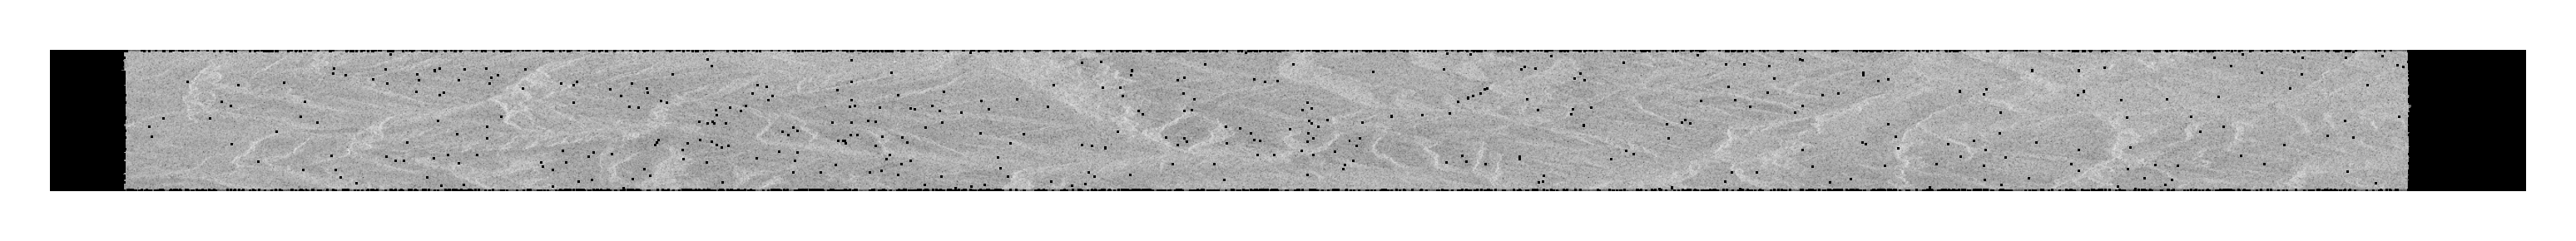

In [12]:
with rasterio.open('openEO_2024-08-21Z.tif') as src:

    # Initialize the figure with a custom dpi
    fig, ax = plt.subplots(dpi=600)

    # Create a grayscale colormap with black as no data
    cmap = plt.cm.gray
    cmap.set_bad(color='black')

    # Visualize the image
    ax.set_axis_off()
    show(src.read(1), cmap=cmap, ax=ax)